Code outline

Required packages:

Preparing dataset for infercnv:
- Filter and normalize
- Reference value: average expression of all cells including normal and tumor
- Can provide reference_key as column from adata.obs for annotated normal and tumor

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import infercnvpy as cnv
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter("ignore")

sc.settings.set_figure_params(figsize=(5, 5))

sc.logging.print_header()

c:\Users\21lyb\Documents\CSCB-2025-Final\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


numpy	2.0.1
pandas	2.2.3
scanpy	1.11.1
infercnvpy	0.6.0
matplotlib	3.10.1
----	----
h5py	3.12.1
llvmlite	0.44.0
jupyter_client	8.6.3
igraph	0.11.8
defusedxml	0.7.1
joblib	1.4.2
natsort	8.4.0
setuptools	75.8.0
pywin32	308
Pygments	2.19.1
traitlets	5.14.3
ipython	9.1.0
texttable	1.7.0
session-info2	0.1.2
mkl-service	2.4.0
asttokens	3.0.0
jupyter_core	5.7.2
numba	0.61.2
platformdirs	4.3.7
anndata	0.11.4
ipykernel	6.29.5
charset-normalizer	3.4.1
psutil	5.9.0
pyreadr	0.5.3
pyzmq	26.2.0
pycairo	1.28.0
executing	0.8.3
stack-data	0.2.0
debugpy	1.8.11
comm	0.2.1
leidenalg	0.10.2
scipy	1.15.2
jedi	0.19.2
pillow	11.2.1
tornado	6.4.2
threadpoolctl	3.6.0
tqdm	4.67.1
typing_extensions	4.12.2
scikit-learn	1.5.2
pytz	2025.2
wcwidth	0.2.5
colorama	0.4.6
cycler	0.12.1
kiwisolver	1.4.8
matplotlib-inline	0.1.6
PyYAML	6.0.2
legacy-api-wrap	1.4.1
six	1.17.0
decorator	5.1.1
prompt-toolkit	3.0.43
parso	0.8.4
python-dateutil	2.9.0.post0
packaging	24.2
pure-eval	0.2.2
pyparsing	3.2.3
----	----
Python	3.11.11 | packaged by Anaconda, Inc. | (main, Dec 11 2024, 16:34:19) [MSC v.1929 64 bit (AMD64)]
OS	Windows-10-10.0.26100-SP0
CPU	12 logical CPU cores, Intel64 Family 6 Model 165 Stepping 2, GenuineIntel
GPU	ID: 0, NVIDIA GeForce GTX 1650 Ti, Driver: 560.70, Memory: 4096 MiB
Updated	2025-04-30 03:14

In [2]:
# Helper functions
def qc(adata,
    mt_threshold_pct=20,
    min_genes=200,
    max_counts=50000,
    min_cells=3,
    min_mean=0.0125,
    max_mean=6,
    min_disp=0.25):

    adata1 = adata.copy()

    # Find MT genes
    adata1.var['mt'] = adata1.var_names.str.startswith('MT-')
    sc.pp.calculate_qc_metrics(adata1, qc_vars=['mt'],
                            percent_top=None,
                            log1p=False,
                            inplace=True)

    # Filter out cells based on MT genes
    adClean = adata1[adata1.obs['pct_counts_mt']<mt_threshold_pct,:].copy()

    # Filter out cells based on number of genes expressed
    sc.pp.filter_cells(adClean, min_genes=min_genes)

    # Filter out cells based on total counts
    sc.pp.filter_cells(adClean, max_counts=max_counts)

    # Filter out genes expressed in few cells
    sc.pp.filter_genes(adClean, min_cells=min_cells)

    # Normalize and log transform
    adNorm = adClean.copy()
    adNorm.layers['counts'] = adNorm.X.copy()
    sc.pp.normalize_total(adNorm, target_sum=1e4)
    sc.pp.log1p(adNorm)

    # Detect highly variable genes
    sc.pp.highly_variable_genes(adNorm, min_mean=min_mean, max_mean=max_mean, min_disp=min_disp)

    # PCA
    sc.tl.pca(adNorm, use_highly_variable=True)

    sc.pl.pca_variance_ratio(adNorm,50)

    return adNorm

In [3]:
adata = cnv.datasets.maynard2020_3k()

In [4]:
# adata = qc(adata)

In [5]:
'''
# Calculate K-nearest neighbors distances
n_neighbors = 20
n_pcs = 20
sc.pp.neighbors(adata,n_neighbors=n_neighbors,n_pcs=n_pcs)
'''

'\n# Calculate K-nearest neighbors distances\nn_neighbors = 20\nn_pcs = 20\nsc.pp.neighbors(adata,n_neighbors=n_neighbors,n_pcs=n_pcs)\n'

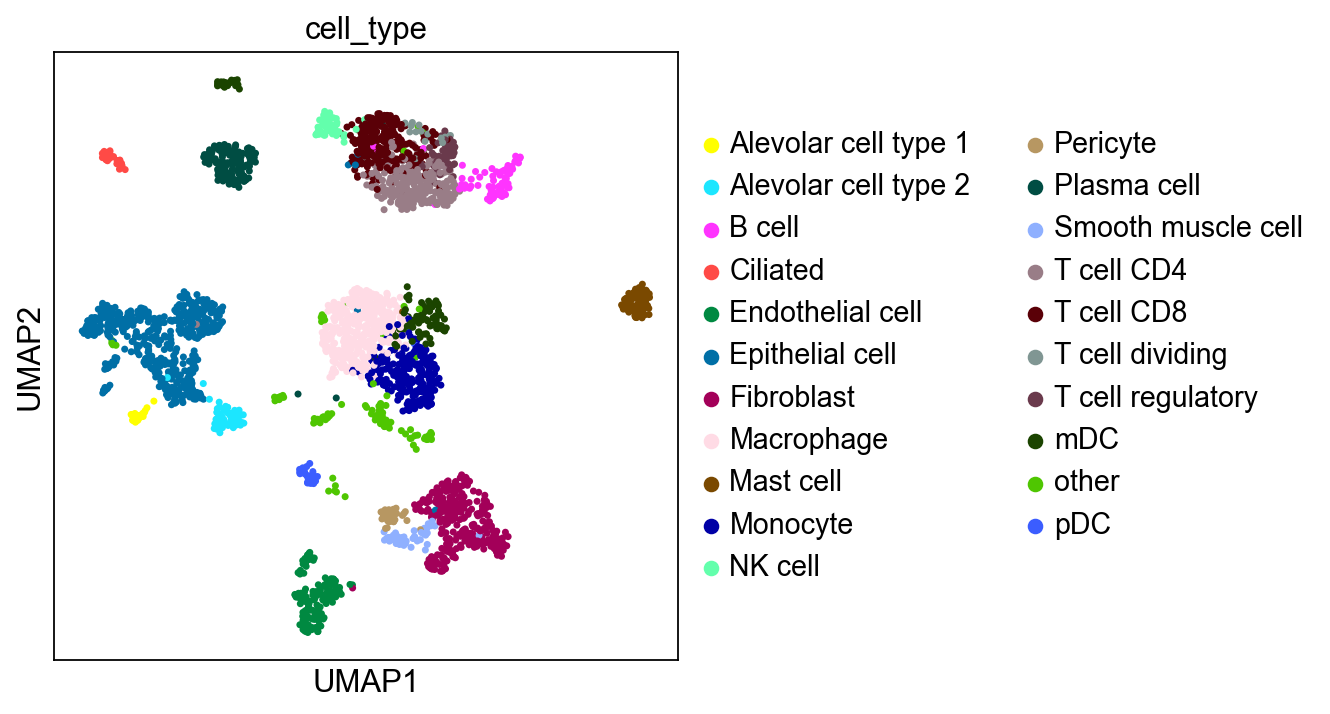

In [6]:
sc.pl.umap(adata, color="cell_type")

### Running infercnv

In [7]:
# Run infercnv

# cell type annotation
reference_key = 'cell_type'
# cell type categories to include
reference_cat = [
    'B cell',
    'Macrophage',
    'Mast cell',
    'Monocyte',
    'NK cell',
    'Plasma cell',
    'T cell CD4',
    'T cell CD8',
    'T cell regulatory',
    'mDC',
    'pDC'
]

cnv.tl.infercnv(adata,reference_key=reference_key,reference_cat=reference_cat)

100%|██████████| 1/1 [00:33<00:00, 33.51s/it]


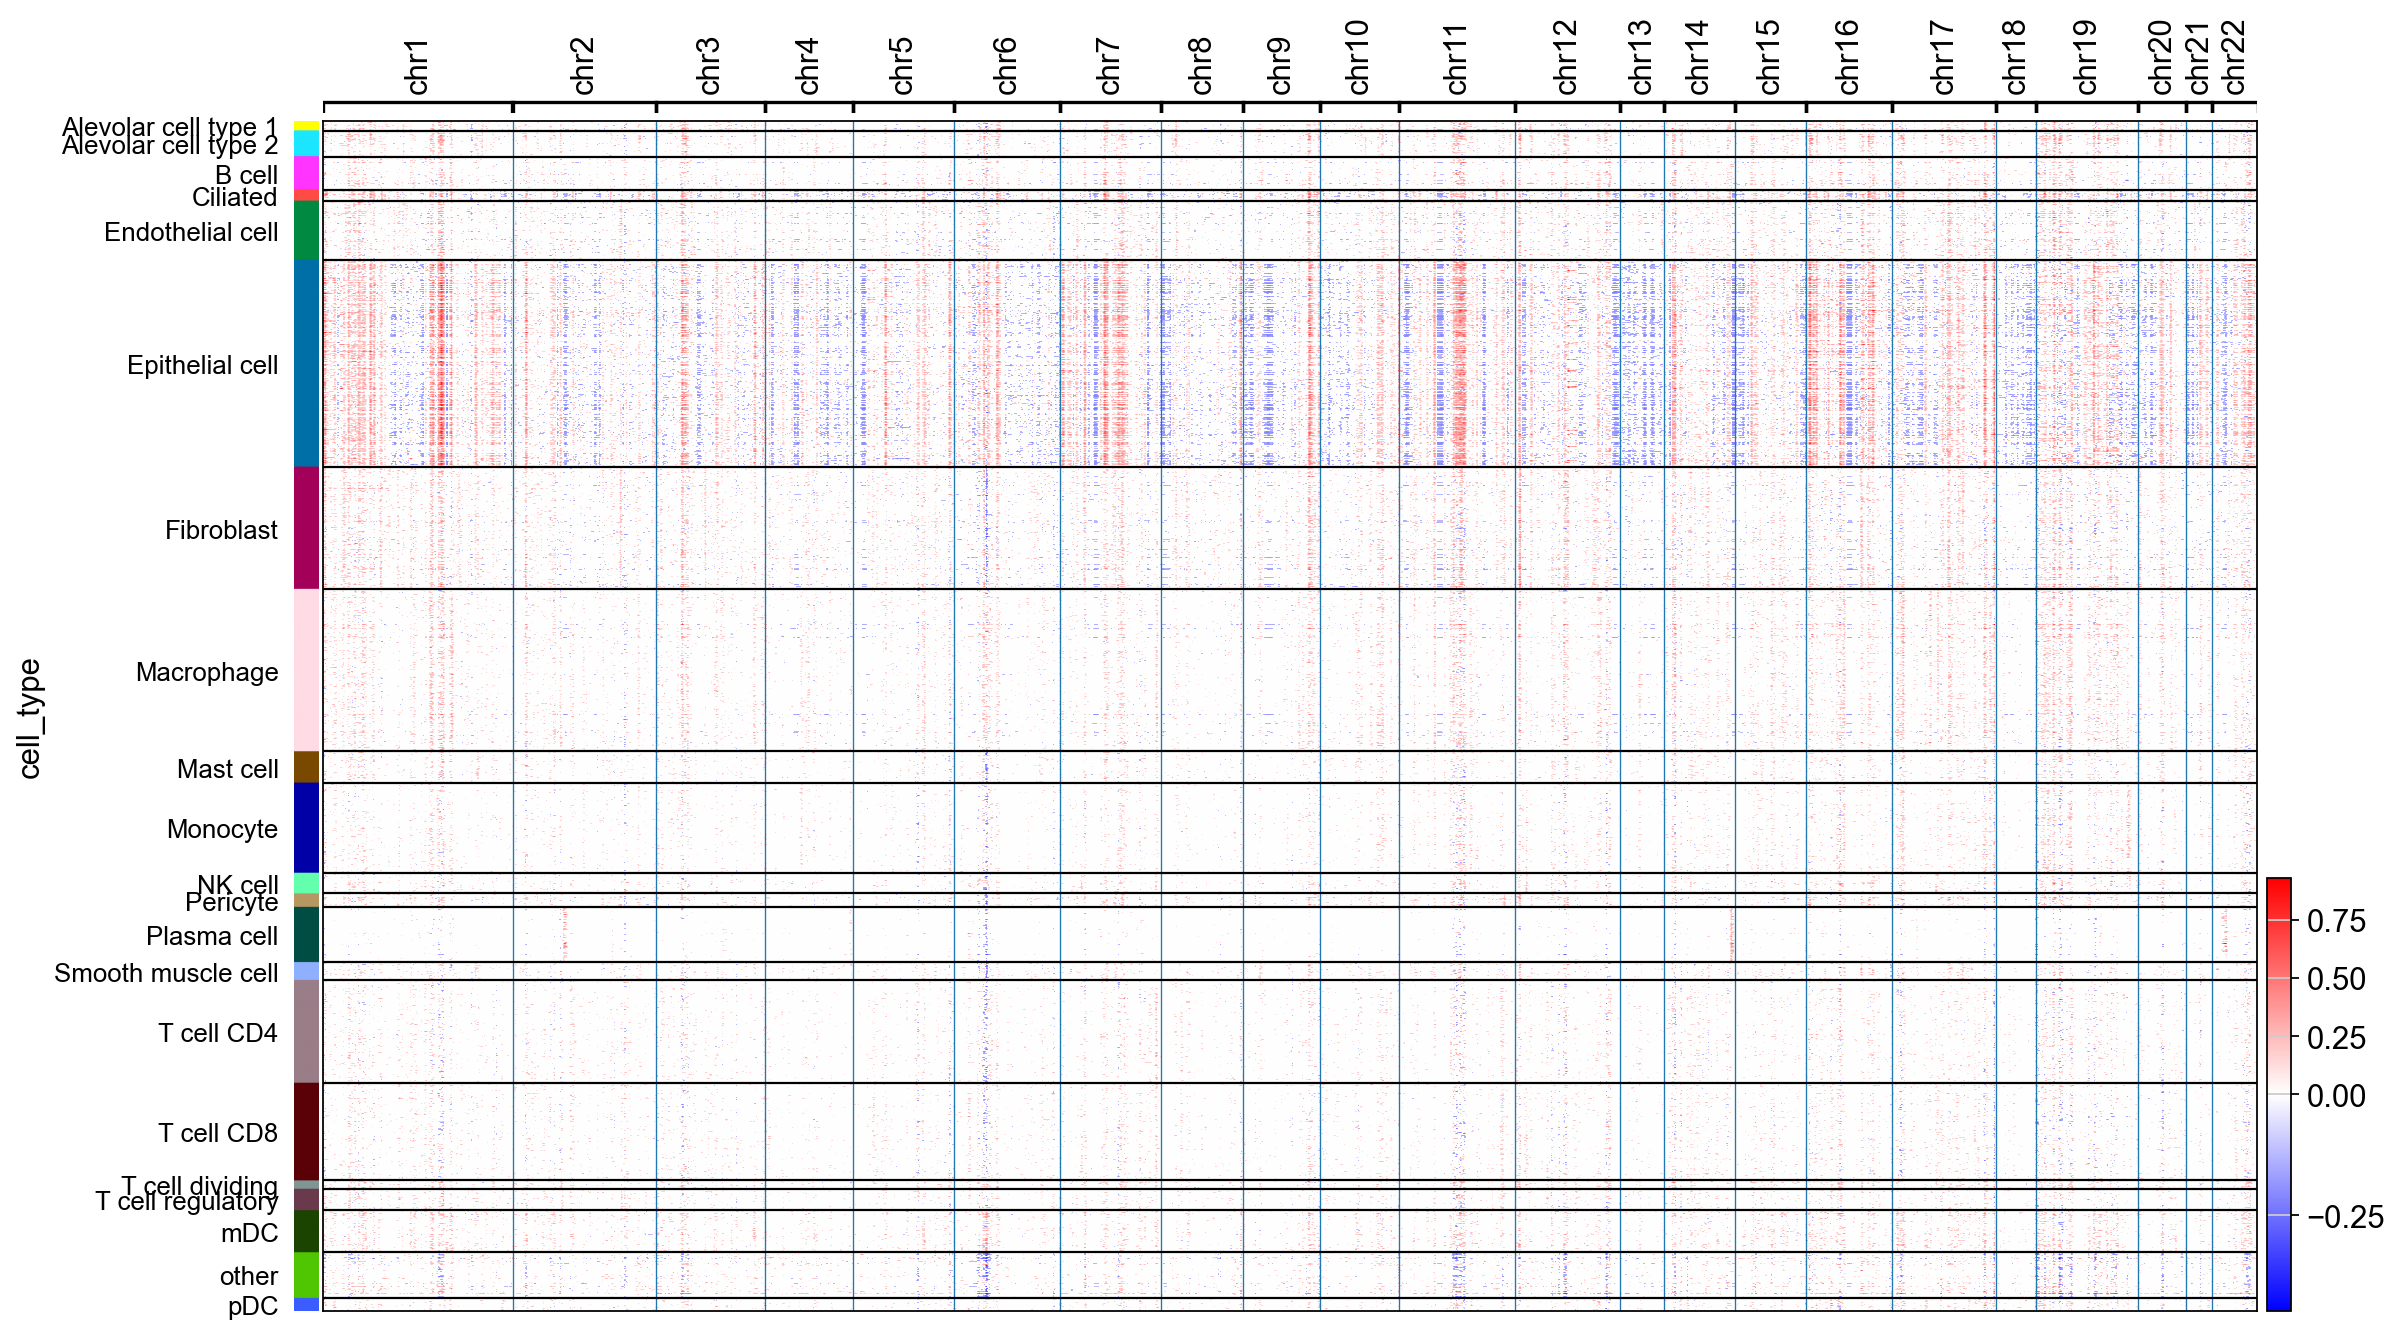

In [8]:
# Plot smoothed gene expression by cell type and chromosome
cnv.pl.chromosome_heatmap(adata, groupby="cell_type")

### Clustering

In [9]:
cnv.tl.pca(adata)
cnv.pp.neighbors(adata)
cnv.tl.leiden(adata)

categories: 0, 1, 2, etc.
var_group_labels: chr1, chr2, chr3, etc.


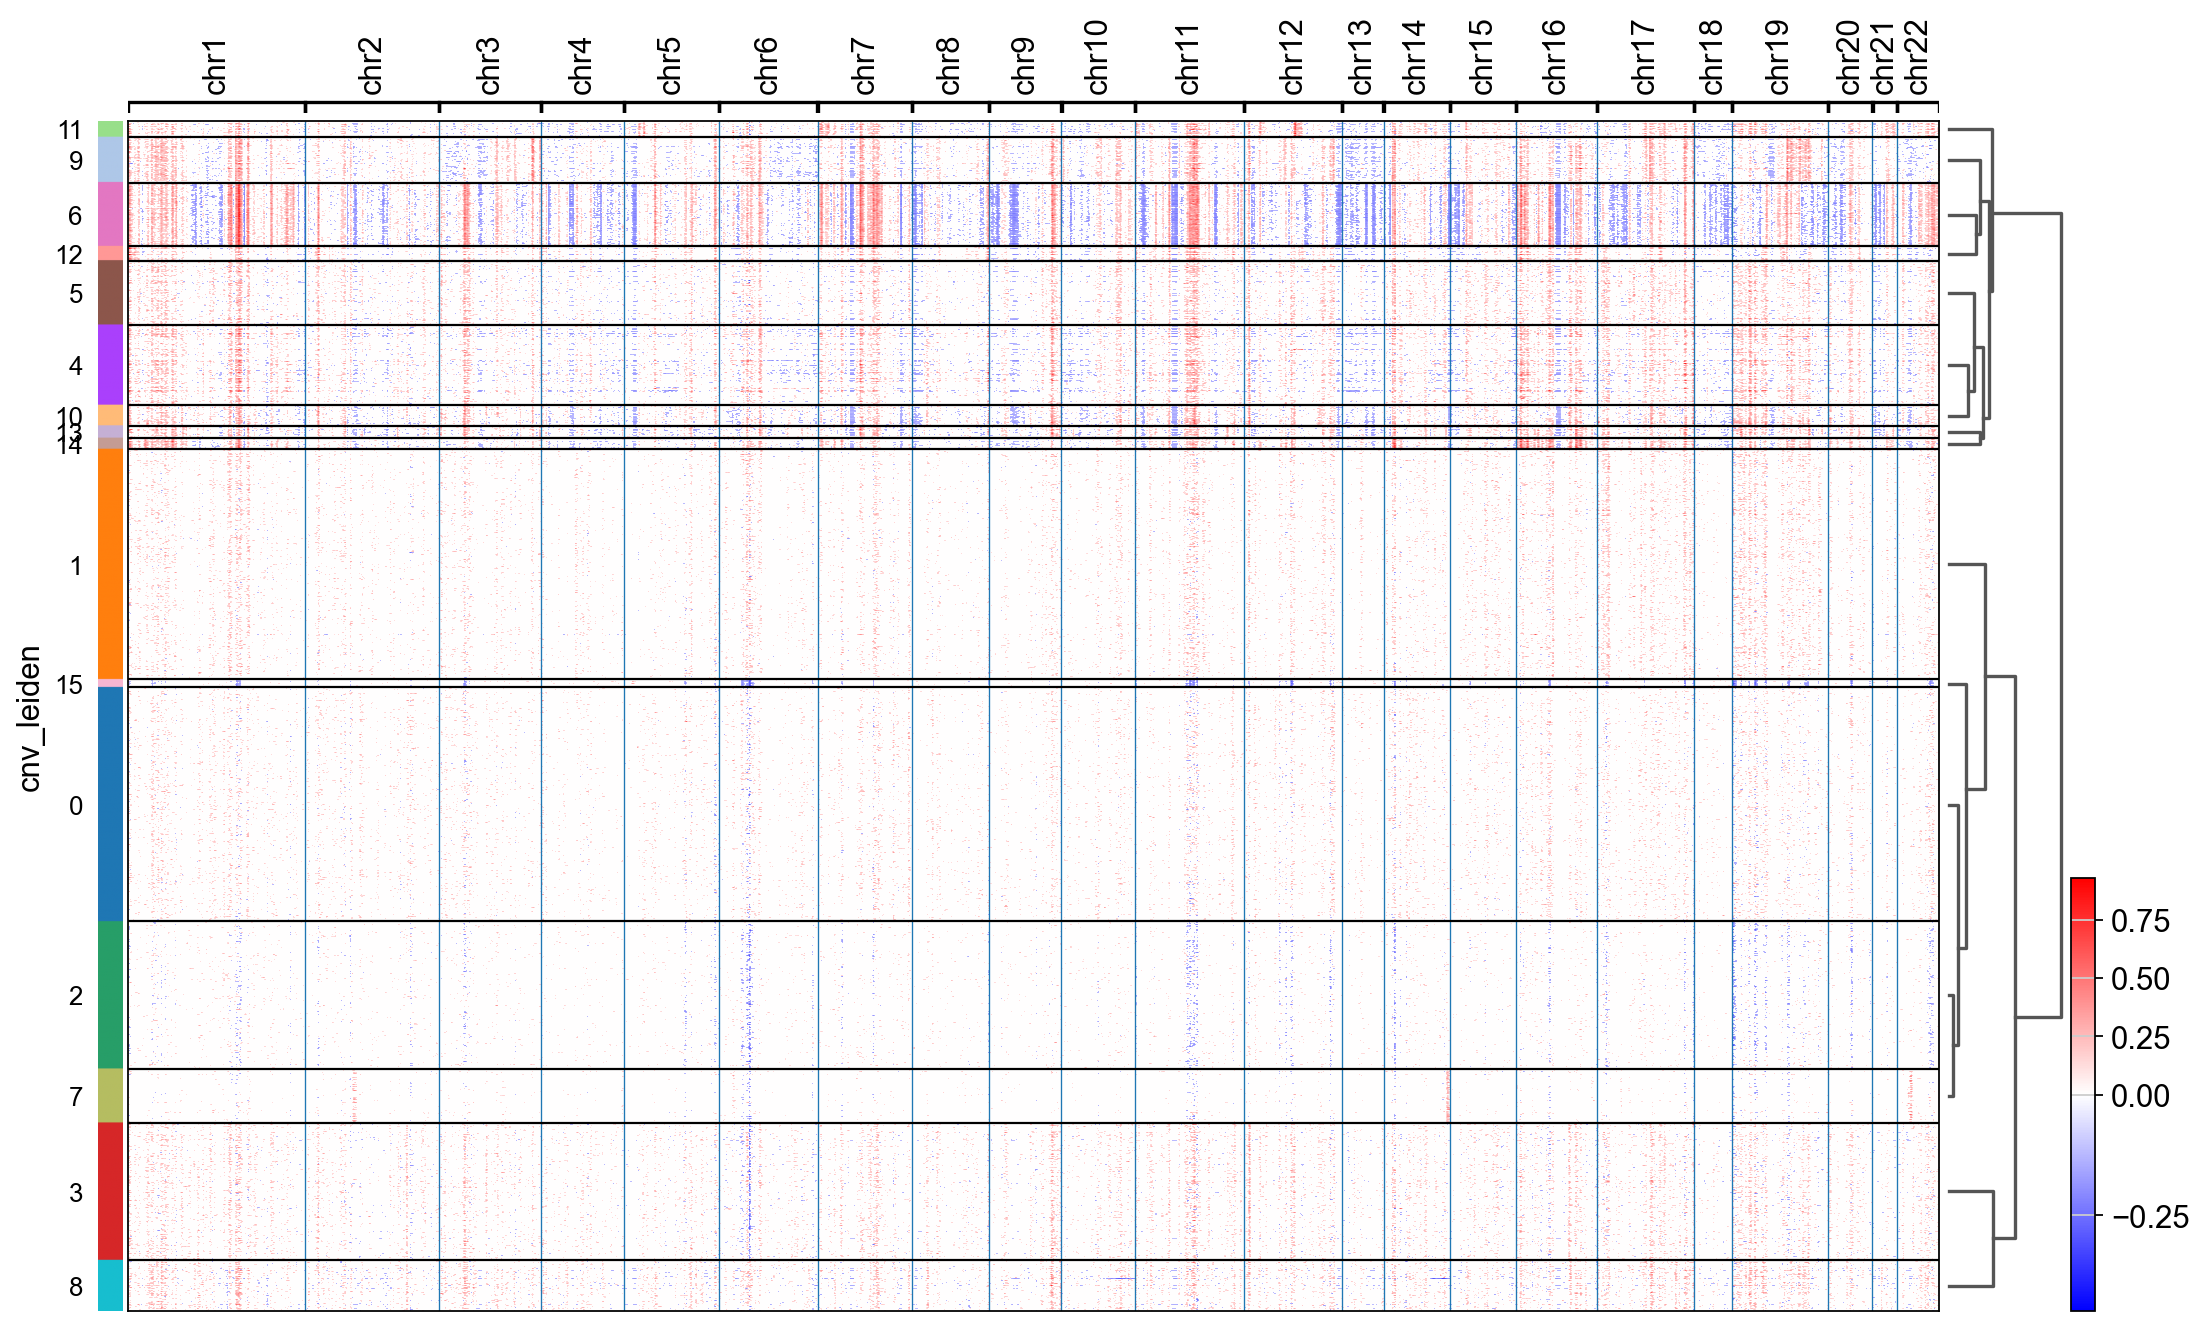

In [10]:
cnv.pl.chromosome_heatmap(adata, groupby="cnv_leiden", dendrogram=True)

### UMAP

In [11]:
cnv.tl.umap(adata)
cnv.tl.cnv_score(adata)

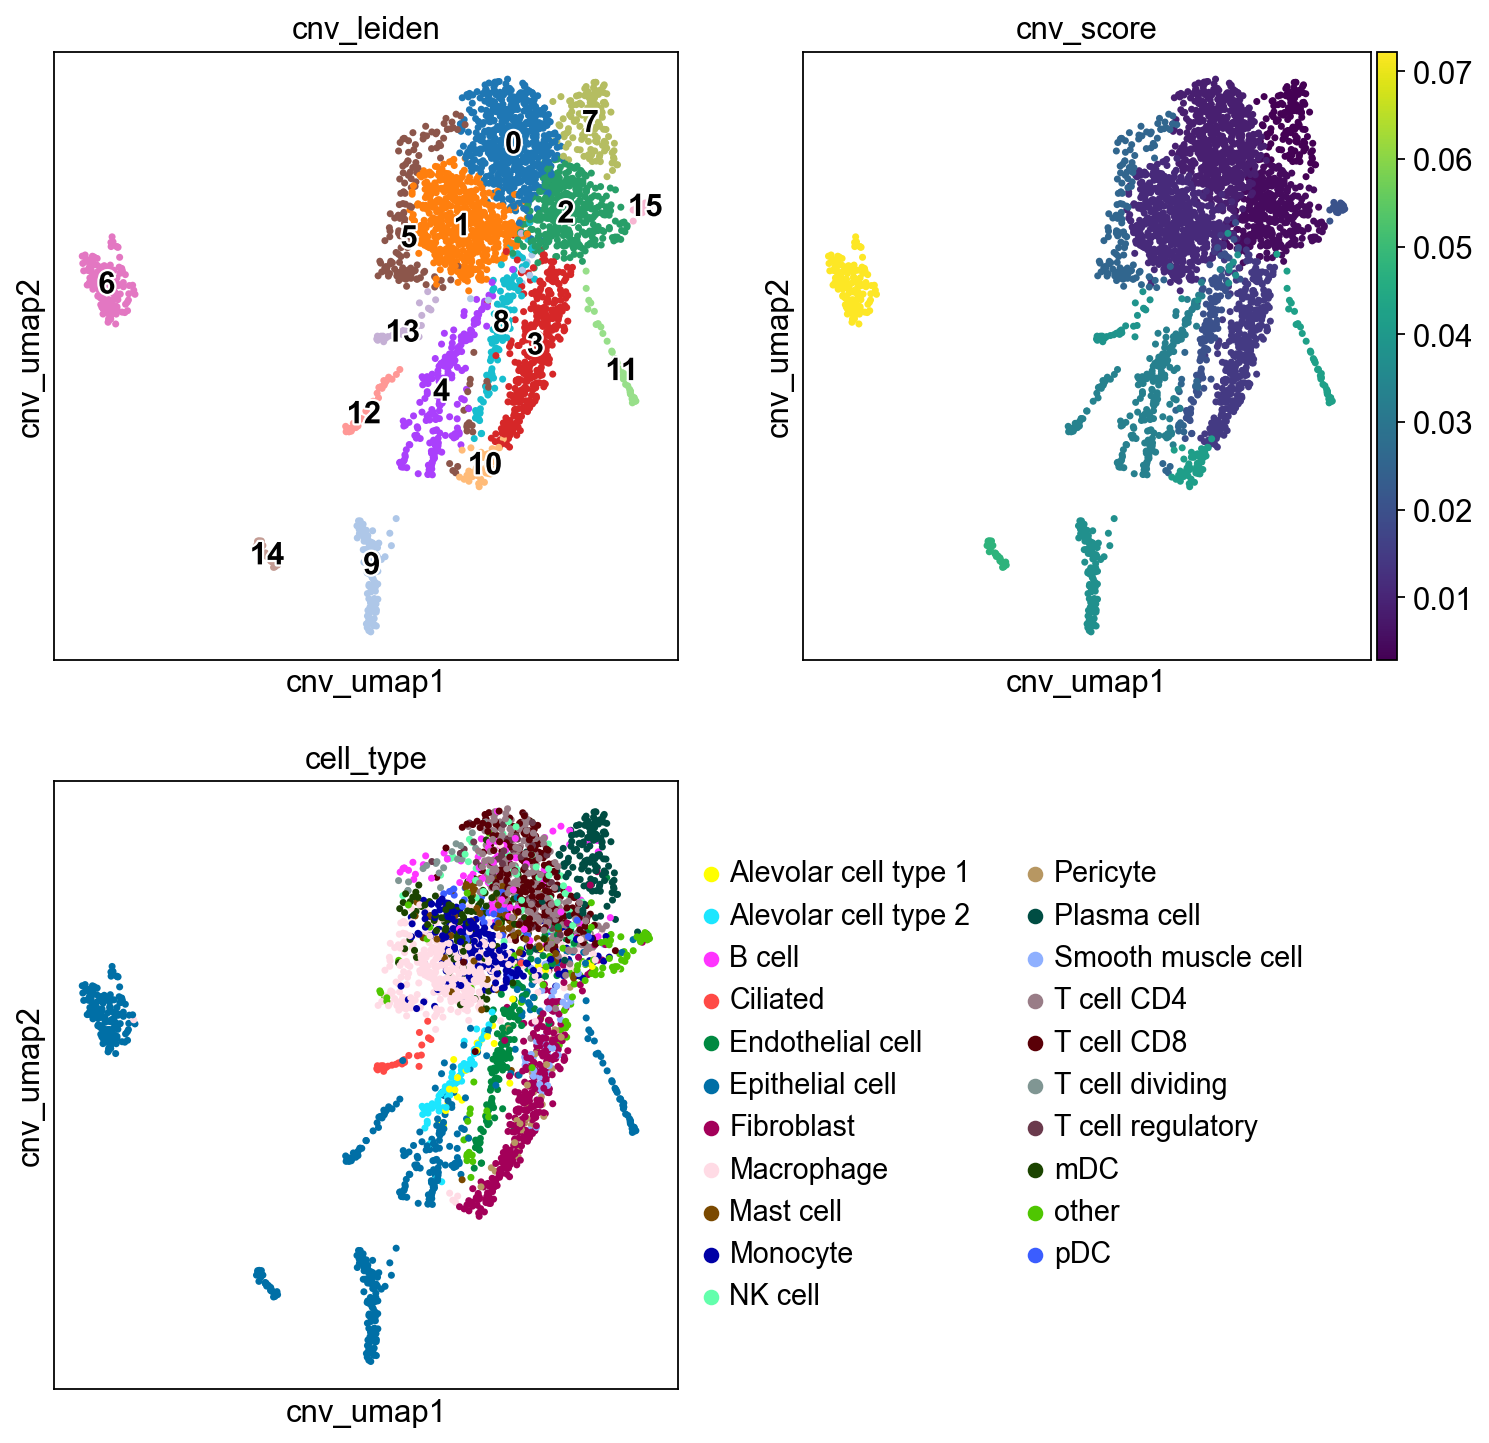

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(11, 11))
ax4.axis("off")
cnv.pl.umap(
    adata,
    color="cnv_leiden",
    legend_loc="on data",
    legend_fontoutline=2,
    ax=ax1,
    show=False,
)
cnv.pl.umap(adata, color="cnv_score", ax=ax2, show=False)
cnv.pl.umap(adata, color="cell_type", ax=ax3)

# possible tumor clusters: 6, 14, 9, 12, 4, 10, 11, 13, 5, 15, 8

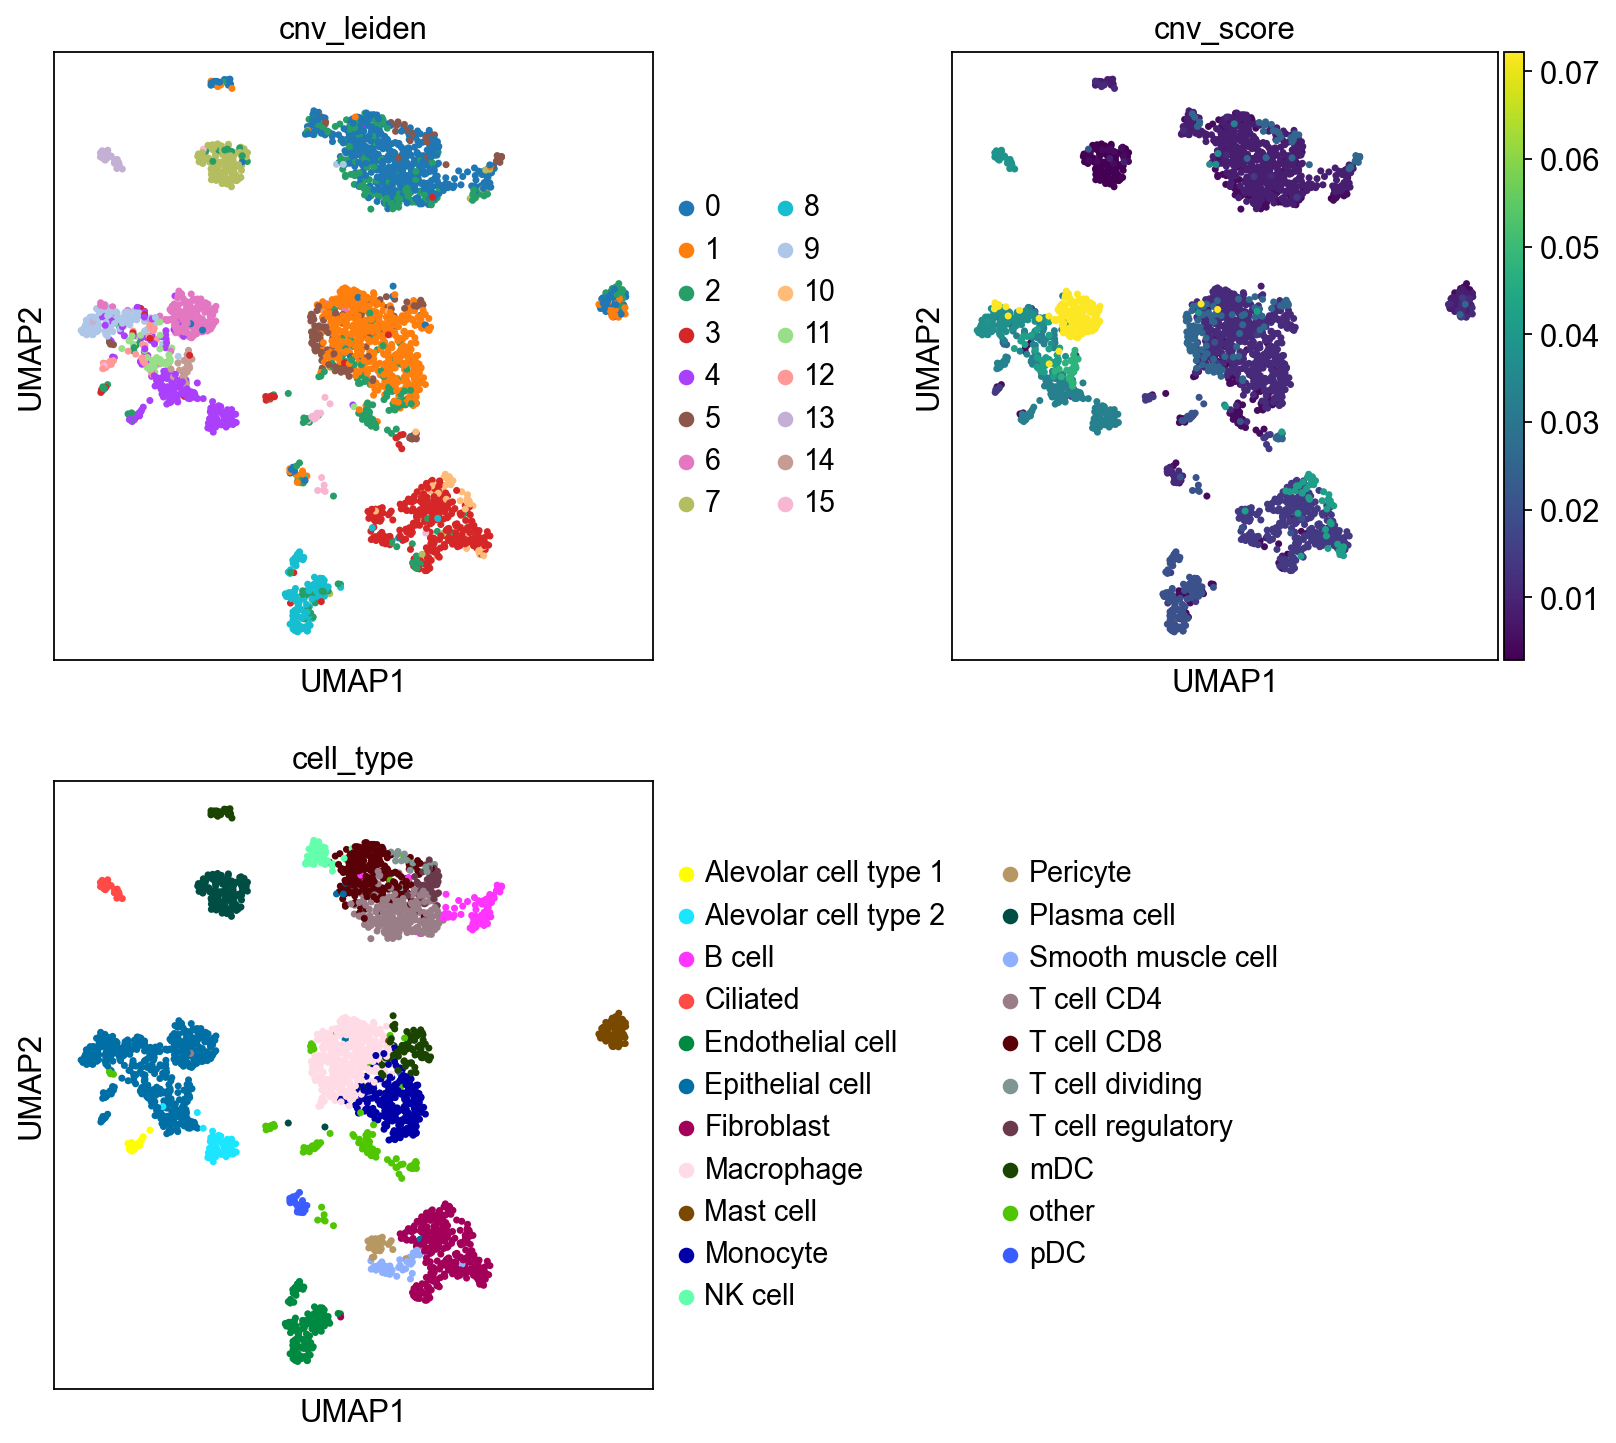

In [13]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 11), gridspec_kw={"wspace": 0.5})
ax4.axis("off")
sc.pl.umap(adata, color="cnv_leiden", ax=ax1, show=False)
sc.pl.umap(adata, color="cnv_score", ax=ax2, show=False)
sc.pl.umap(adata, color="cell_type", ax=ax3)

### Classify tumor cells

In [14]:
tumor_clusters = [6, 14, 9, 12, 4, 10, 11, 13, 5, 15, 8]
adata.obs['cnv_status'] = 'normal'
adata.obs.loc[adata.obs['cnv_leiden'].isin([str(x) for x in tumor_clusters]), 'cnv_status'] = ('tumor')

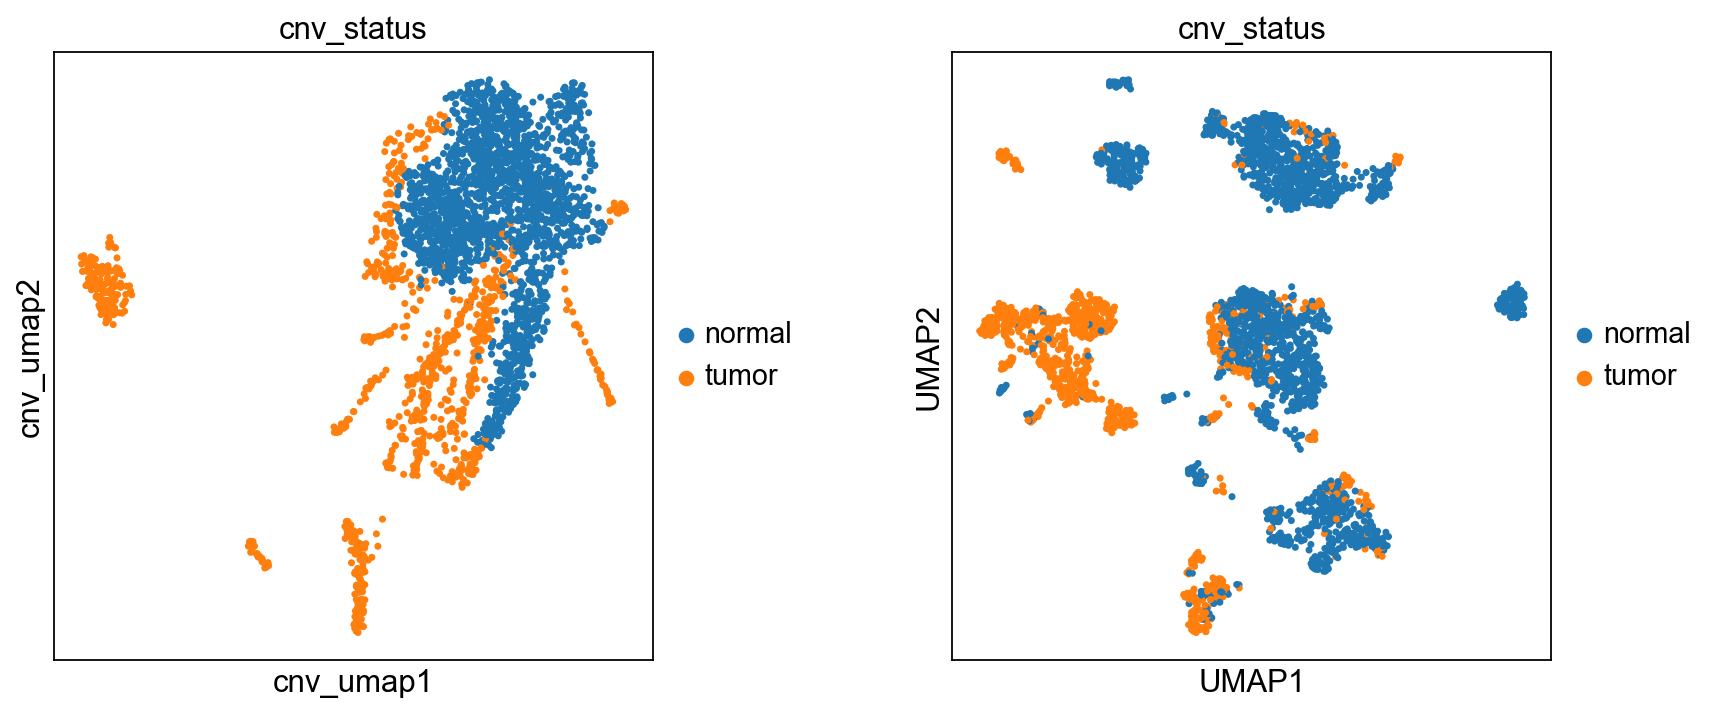

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={"wspace": 0.5})
cnv.pl.umap(adata, color="cnv_status", ax=ax1, show=False)
sc.pl.umap(adata, color="cnv_status", ax=ax2)

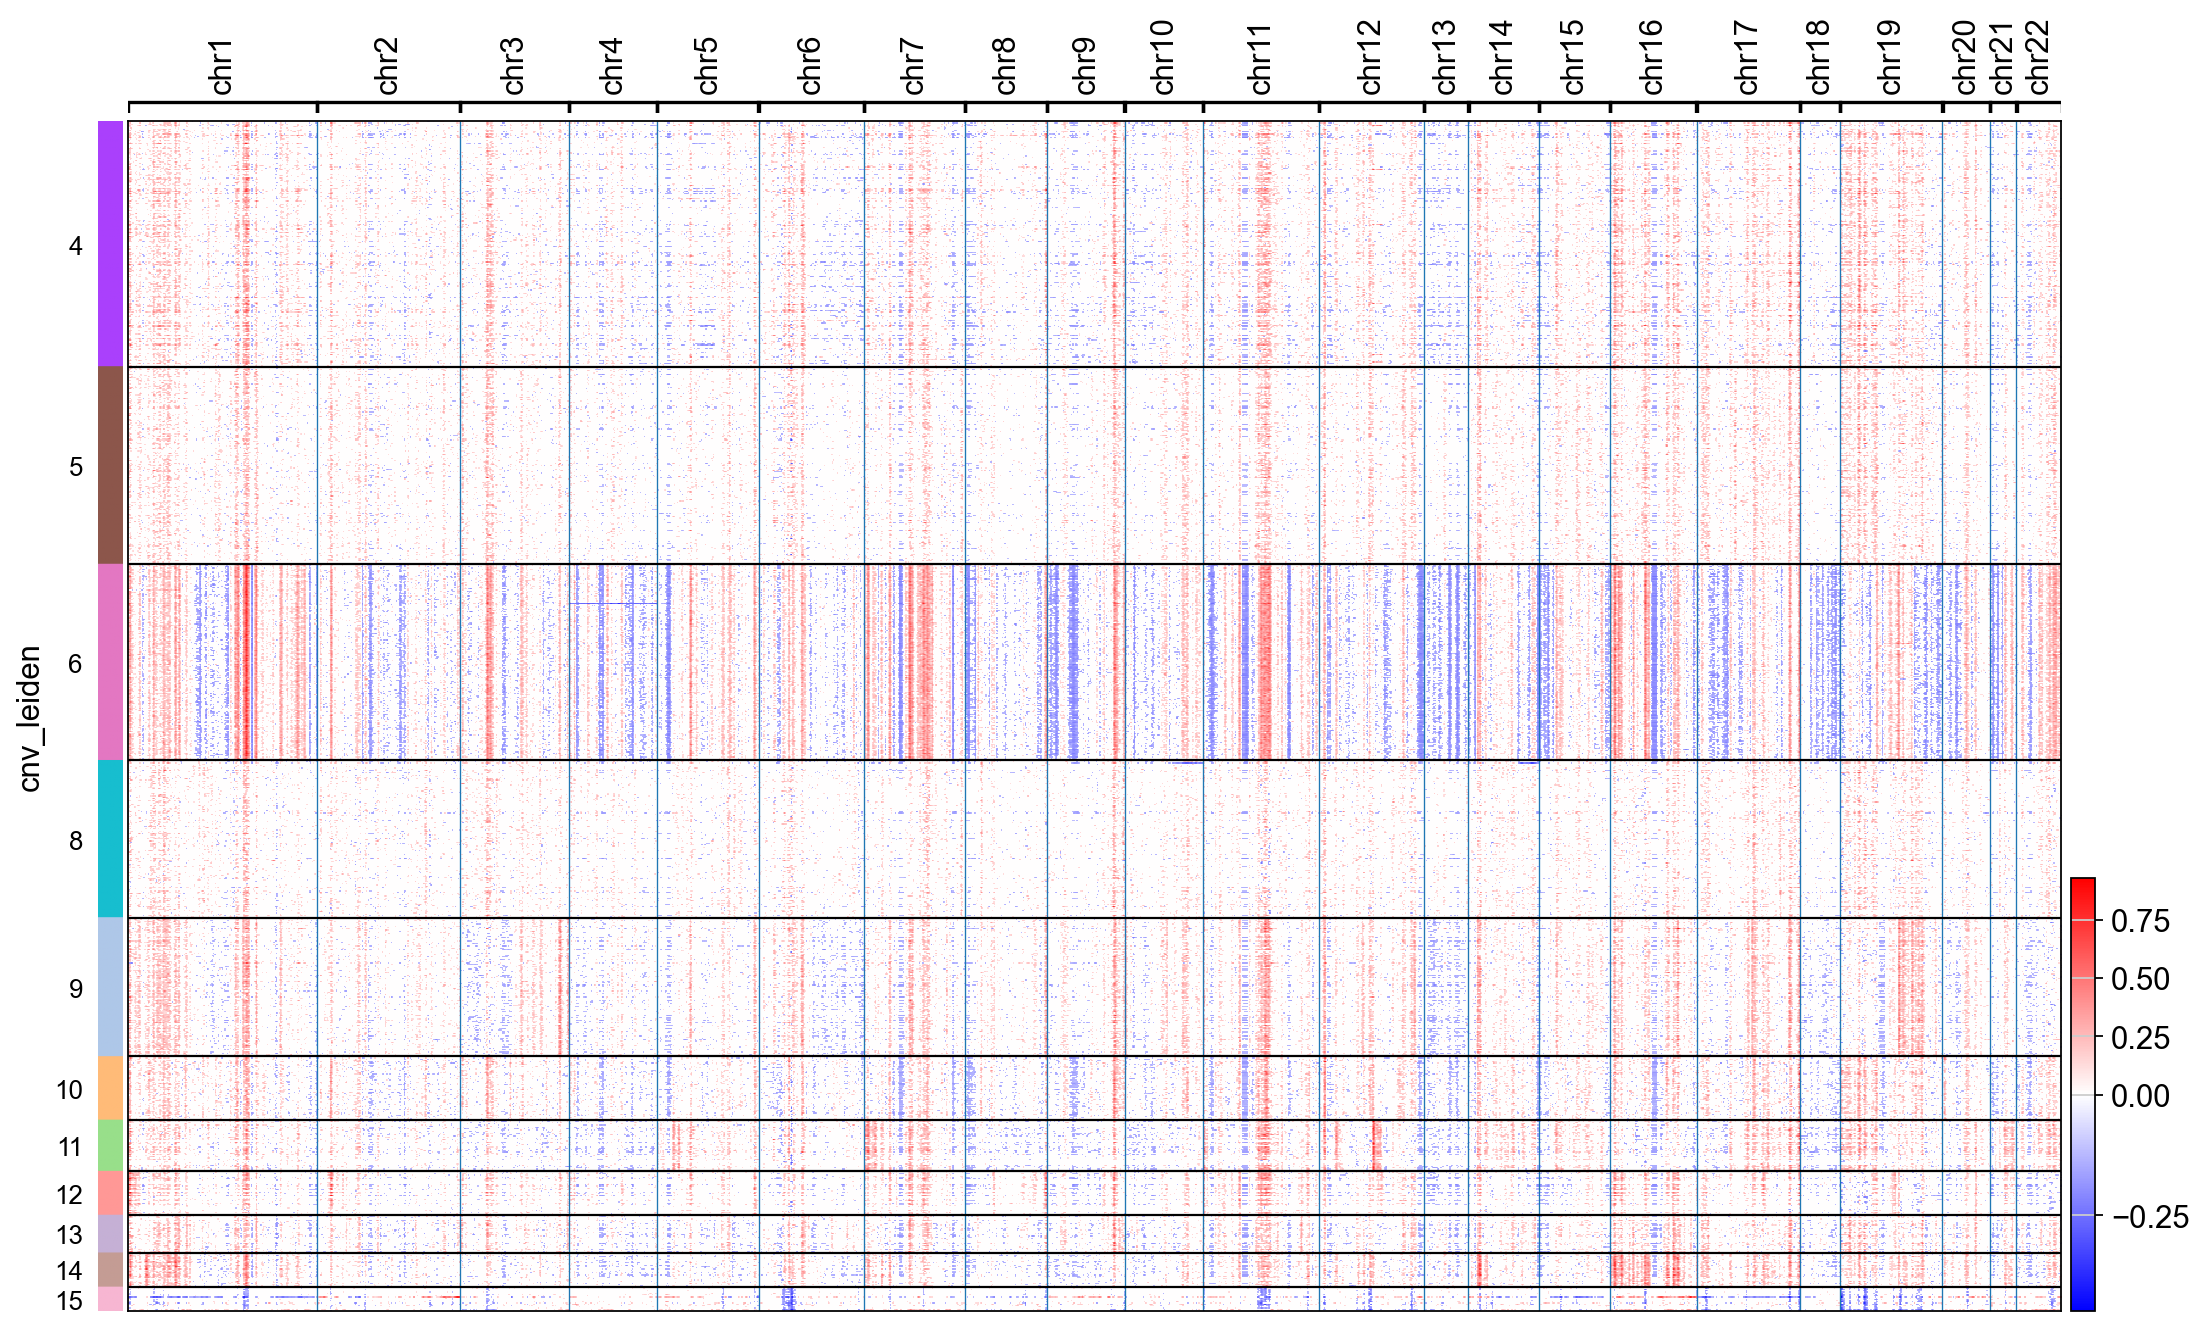

In [16]:
cnv.pl.chromosome_heatmap(adata[adata.obs["cnv_status"] == "tumor", :])

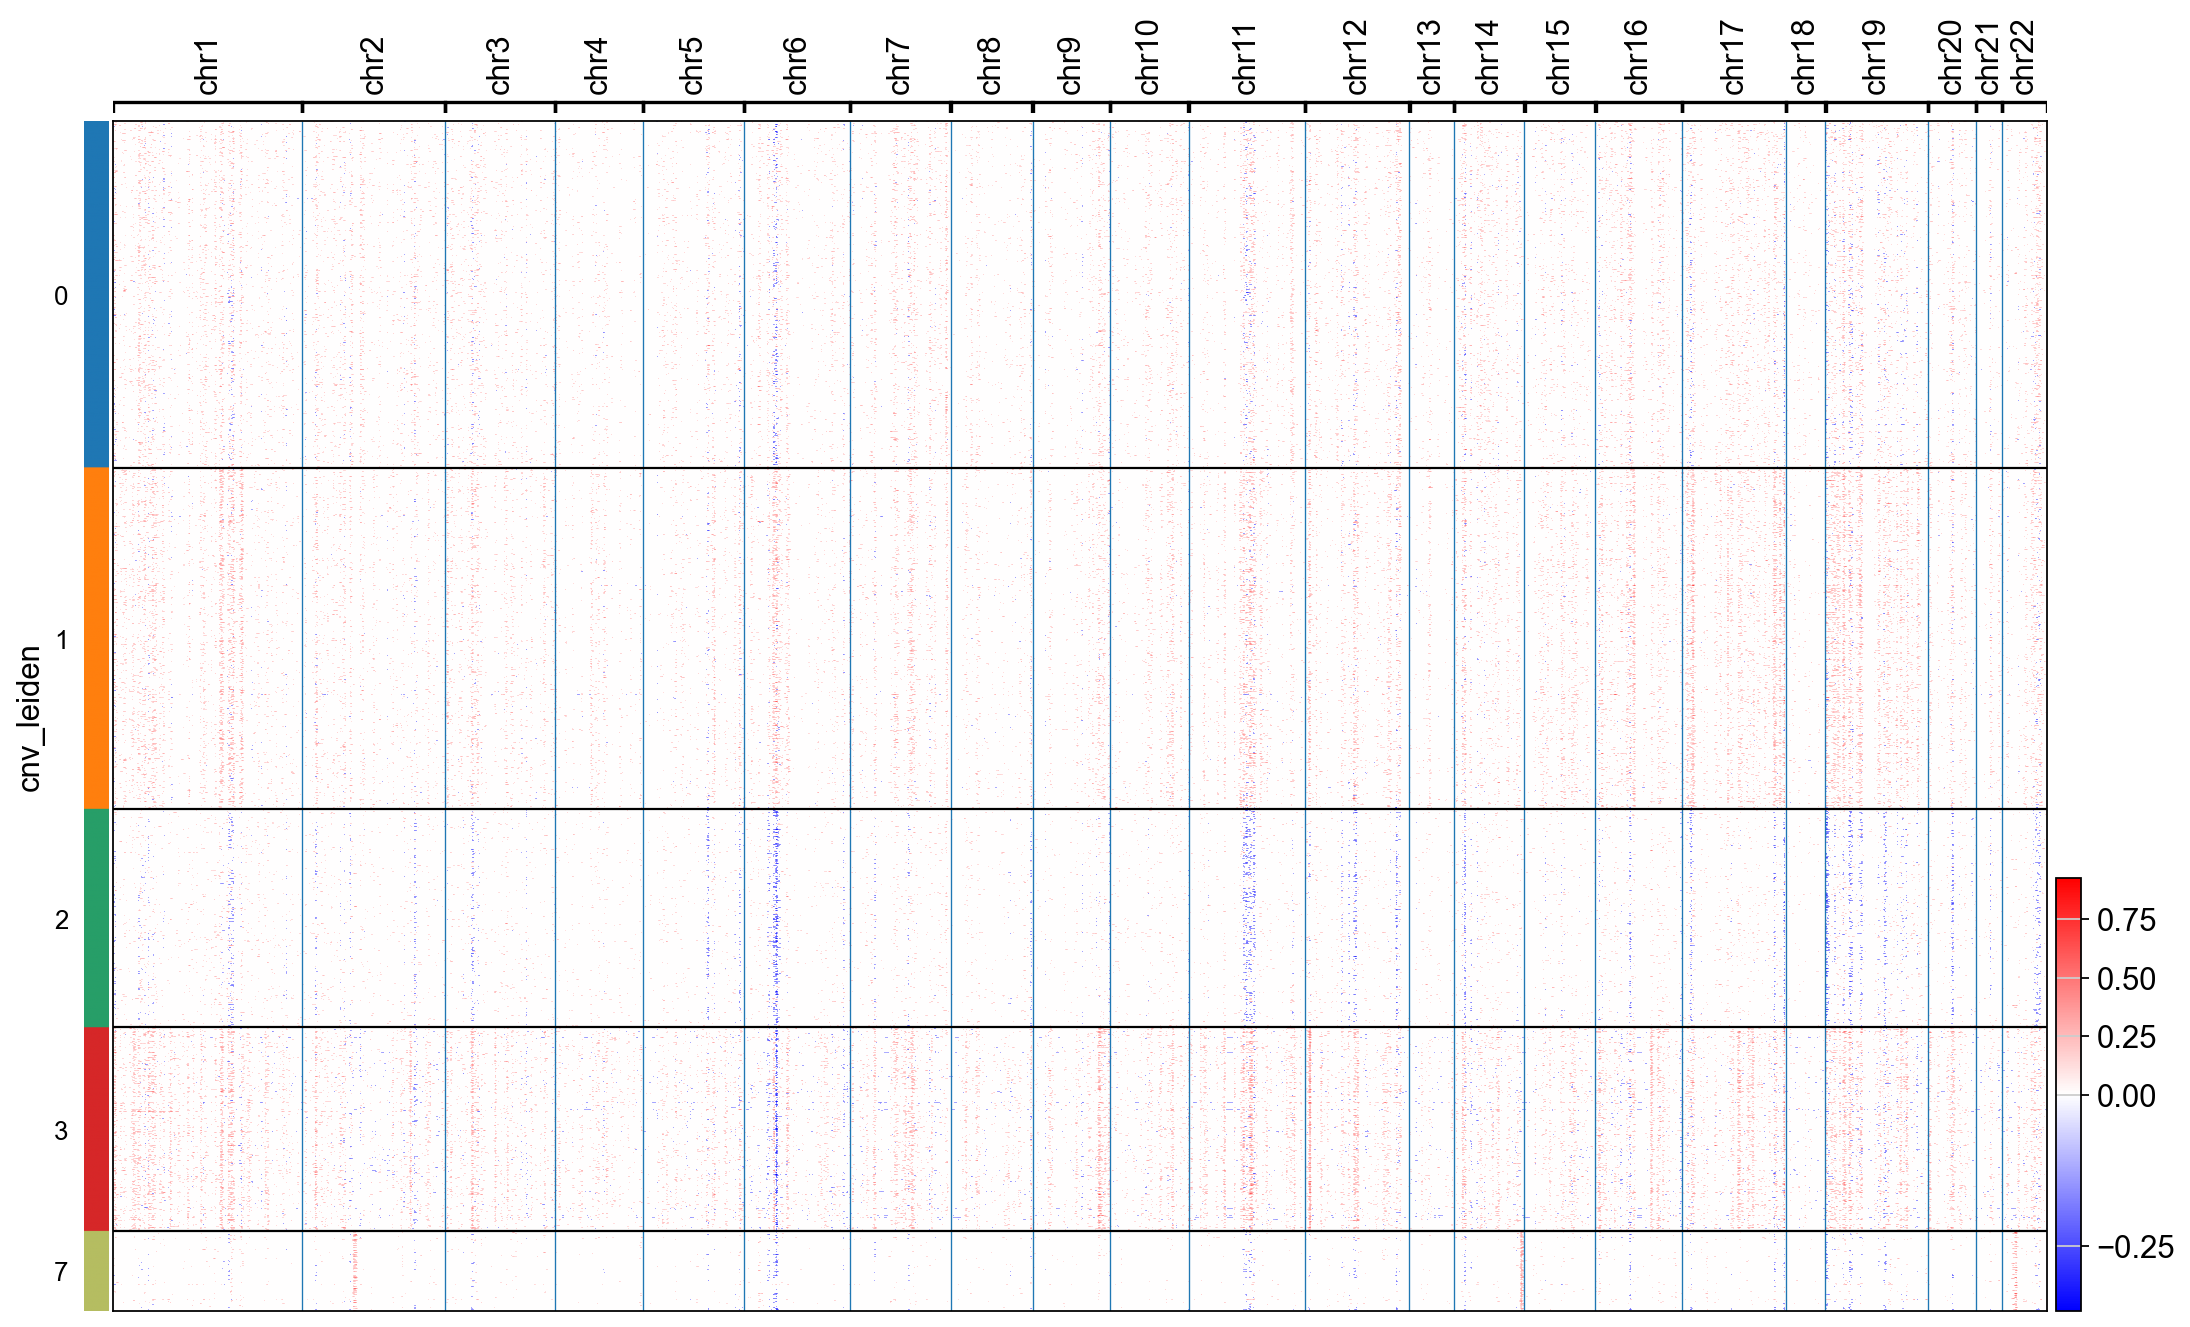

In [17]:
cnv.pl.chromosome_heatmap(adata[adata.obs["cnv_status"] == "normal", :])